# Logistic Model

In [130]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

import pickle


In [131]:
# Import dataframe

df0 = pd.read_pickle('../../Data/Processed/abc_classification_modelling.p')
df0.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [132]:
# Remove non desired data from model (Non predictor data or ethics concern)
df1 = df0.drop(['customer_id'], axis=1)

In [133]:
# Shuffle data
df2 = shuffle(df1, random_state=42)

In [134]:
# Class balance 
df2['signup_flag'].value_counts(normalize=True)

signup_flag
0    0.689535
1    0.310465
Name: proportion, dtype: float64

In [135]:
# Deal with missing values
df2.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [136]:
# Low value count for missing data so we drop
df3 = df2.dropna()

In [137]:
df3.head()

,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
714,0,1.64,M,0.58,27.81,6,3,3,9.270000
605,0,0.88,M,0.63,26.62,9,3,2,8.873333
120,0,0.56,M,0.62,886.78,154,18,4,49.265556
208,0,0.11,M,0.58,1256.19,168,34,5,36.946765
380,0,1.32,M,0.36,739.67,110,21,3,35.222381


([0, 1, 2, 3, 4],
 [Text(0, 0, 'signup_flag'),
  Text(1, 0, 'credit_score'),
  Text(2, 0, 'transaction_count'),
  Text(3, 0, 'product_area_count'),
  Text(4, 0, 'average_basket_value')])

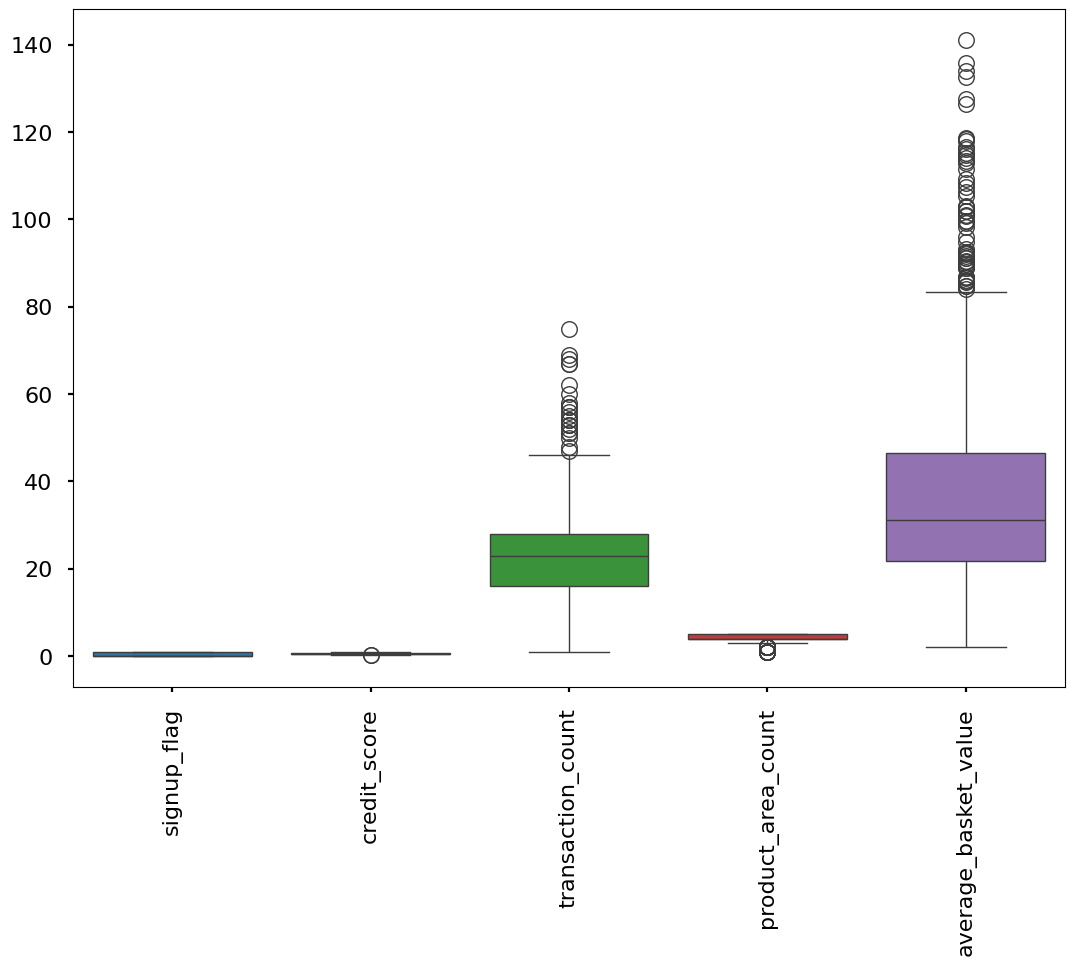

In [138]:
# Check for outliers
sns.boxplot(df3.drop(['total_sales','total_items','distance_from_store'], axis=1))
plt.xticks(rotation=90)

([0, 1, 2],
 [Text(0, 0, 'total_sales'),
  Text(1, 0, 'total_items'),
  Text(2, 0, 'distance_from_store')])

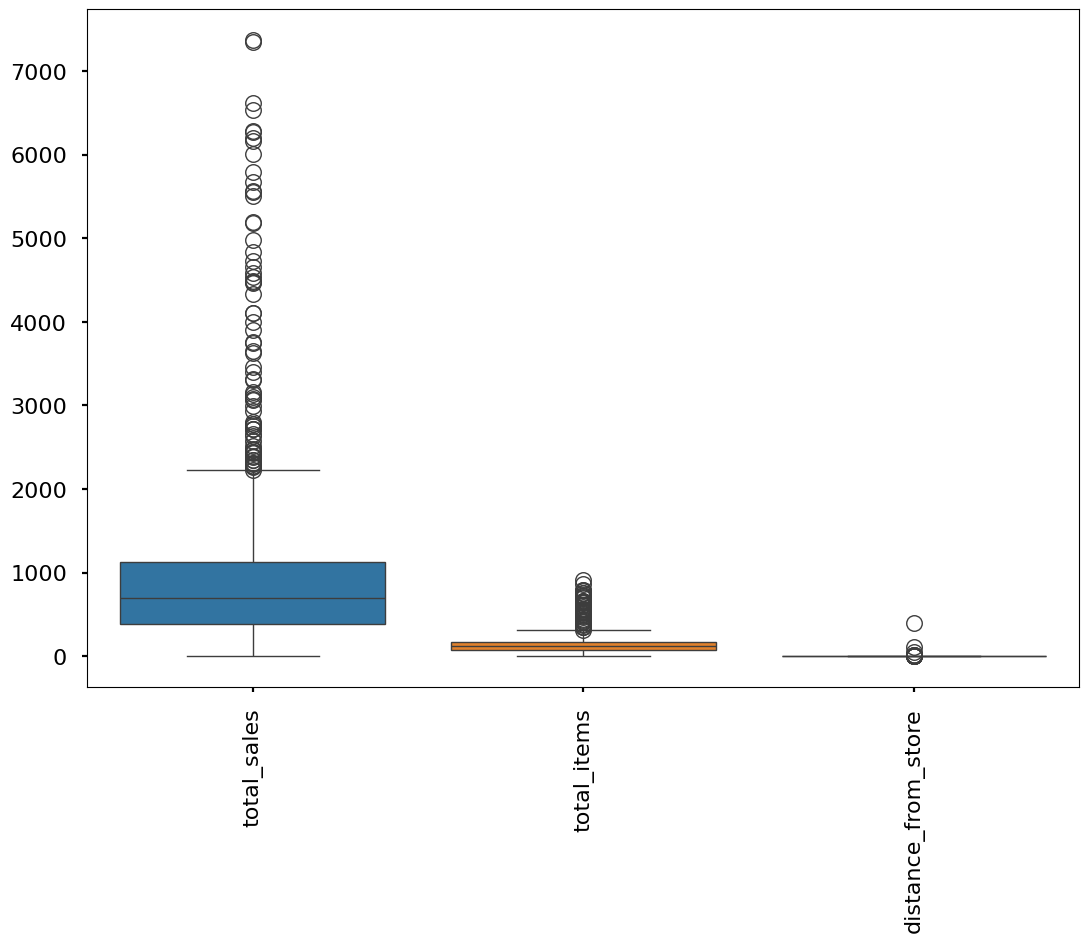

In [139]:
# Check for outliers
sns.boxplot(df3[['total_sales','total_items','distance_from_store']])
plt.xticks(rotation=90)

In [140]:
df3.describe()

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [141]:
# Outlier removal

outlier_columns = ['distance_from_store','total_sales','total_items']

for column in outlier_columns:
    
    lower_quartile = df3[column].quantile(0.25)
    upper_quartile = df3[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    min_border = lower_quartile - 2*iqr
    max_border = upper_quartile + 2*iqr
    
    outliers = df3[(df3[column] < min_border) | (df3[column] > max_border)].index
    print(f'{len(outliers)} outliers detected in column {column}')
    
    df3.drop(outliers, inplace = True)

8 outliers detected in column distance_from_store
54 outliers detected in column total_sales
3 outliers detected in column total_items


C:\Users\max05\AppData\Local\Temp\ipykernel_10244\1364020544.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(outliers, inplace = True)
C:\Users\max05\AppData\Local\Temp\ipykernel_10244\1364020544.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(outliers, inplace = True)
C:\Users\max05\AppData\Local\Temp\ipykernel_10244\1364020544.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.drop(outliers, inplace 

In [142]:
# Split into input 'X' and output 'y'
X = df3.drop(['signup_flag'], axis = 1)
y = df3['signup_flag']

In [143]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y
                                                    )

In [144]:
categorical_vars = ['gender']

one_hot_encoder = OneHotEncoder(sparse_output = False, drop = 'first')

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis=1, inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis=1, inplace=True)

In [145]:
X_train.head(1)

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.07,0.57,746.15,133,24,5,31.089583,1.0


In [146]:
X_test.head(1)

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.03,0.69,266.74,57,9,4,29.637778,1.0


c:\Users\max05\.conda\envs\data-science-env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimal number of features: 7


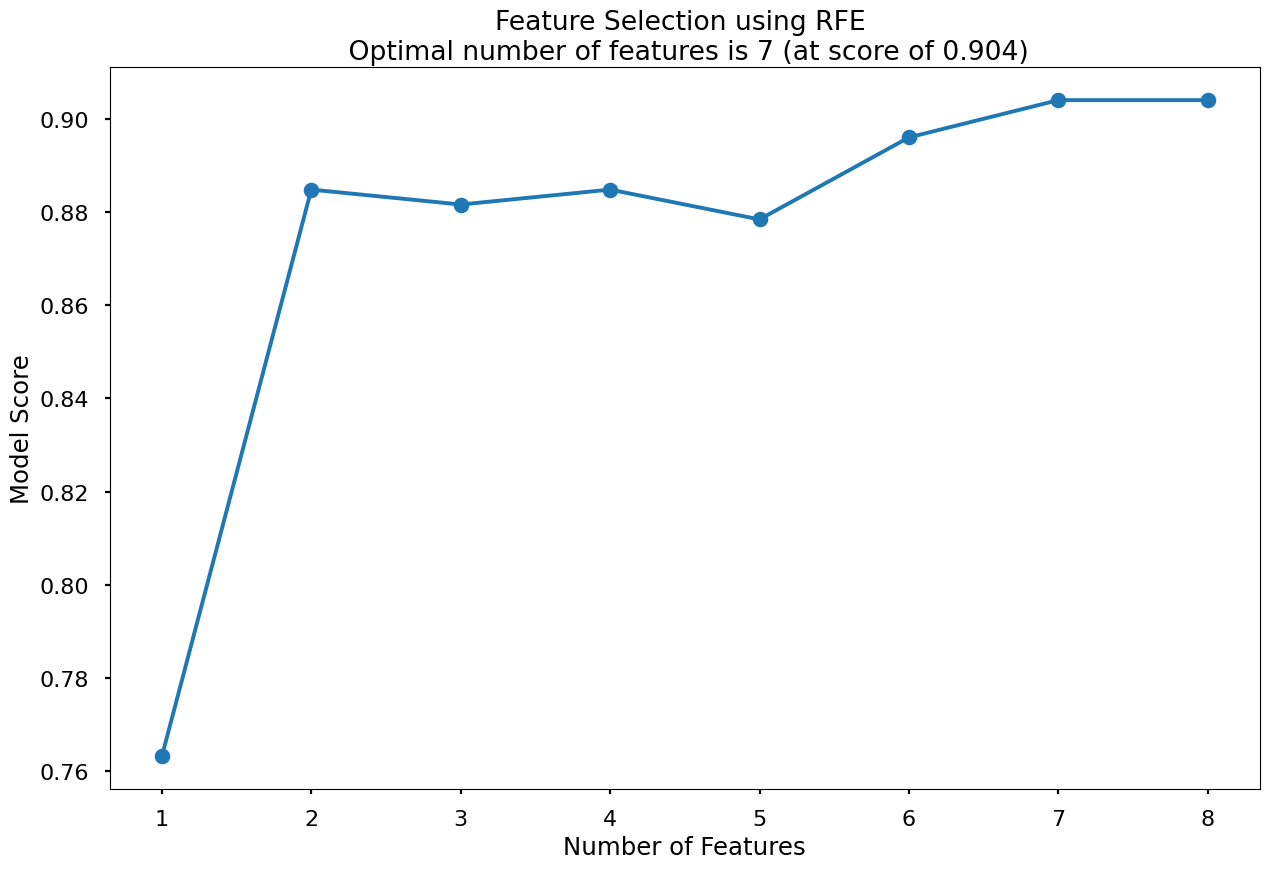

In [147]:
# feature selection with regressive feature elemination
clf = LogisticRegression(random_state=42, max_iter=1000)
feature_selector = RFECV(clf)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f'Optimal number of features: {optimal_feature_count}')

X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# Show results on a graph
plt.plot(range(1, len(fit.cv_results_['mean_test_score'])+1),
         fit.cv_results_['mean_test_score'],
         marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Model Score')
plt.title(f'Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})')
plt.tight_layout()
plt.show()


In [148]:
X_train.head(1)

,distance_from_store,credit_score,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.07,0.57,133,24,5,31.089583,1.0


In [149]:
X_test.head(1)

,distance_from_store,credit_score,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.03,0.69,57,9,4,29.637778,1.0


In [150]:
# Build model
clf = LogisticRegression(random_state=42, max_iter=1000)

In [151]:
# fit model
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [152]:
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1] # Return probability that the customer signed up

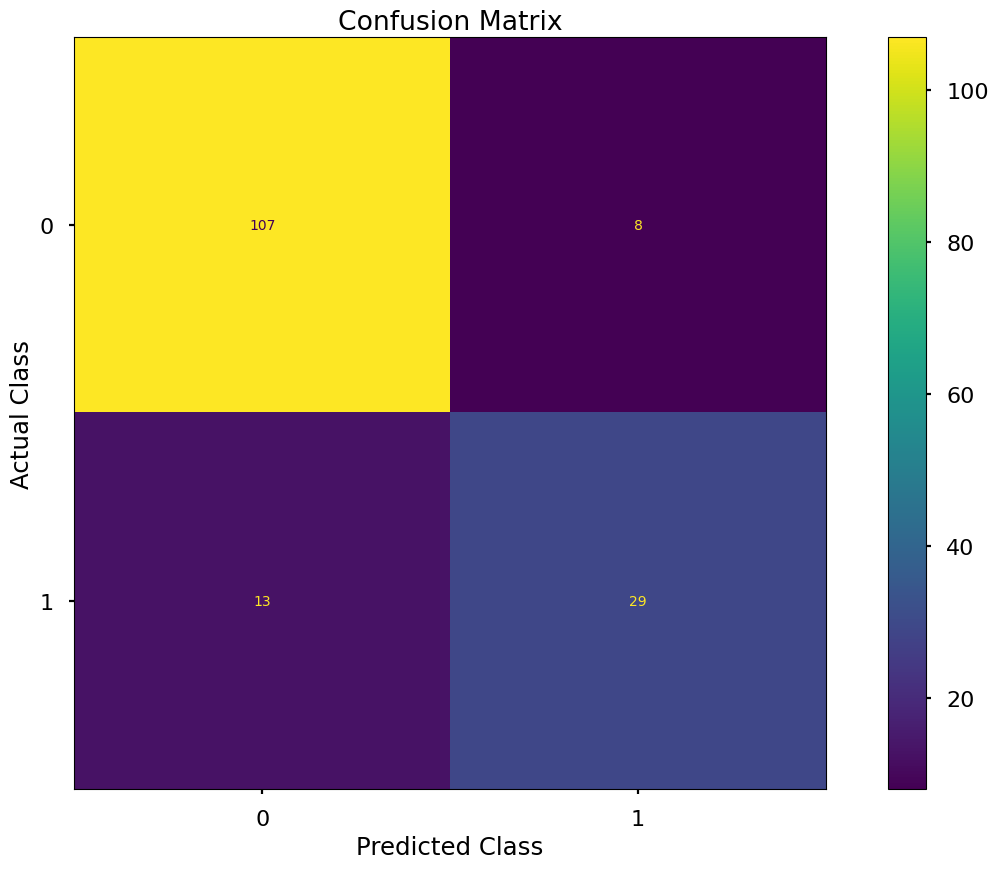

In [153]:
cm = confusion_matrix(y_test,
                      y_pred_class,
                      labels = clf.classes_
                      )

disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                              display_labels = clf.classes_
                              )
disp.plot()
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Calculated classification metrics

In [154]:
# Accuracy: number of correct classifications out of all attempted classifications
accuracy_score(y_test, y_pred_class)

0.8662420382165605

In [155]:
# Precision: Out of the predicted positive classifications, how many where right
precision_score(y_test, y_pred_class)

0.7837837837837838

In [156]:
# Recall: Out of the positive classifications, how many did we predict
recall_score(y_test, y_pred_class)

0.6904761904761905

In [157]:
# F1 : Harmonic mean of precision and recall
f1_score(y_test, y_pred_class)

0.7341772151898734

In [158]:
# Find the optimal threshold for the logistic classification of the model

thresholds = np.arange(0,1,0.01) # create a list of increment 0.01 for all the values between 0 and 1

precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    pred_class = (y_pred_prob >= threshold) * 1
    
    precision = precision_score(y_test, pred_class, zero_division=0)
    precision_scores.append(precision)
    
    recall = recall_score(y_test, pred_class, zero_division=0)
    recall_scores.append(recall)
    
    f1 = f1_score(y_test, pred_class, zero_division=0)
    f1_scores.append(f1)
    

max_f1 = max(f1_scores)
max_f1_idx = f1_scores.index(max_f1)

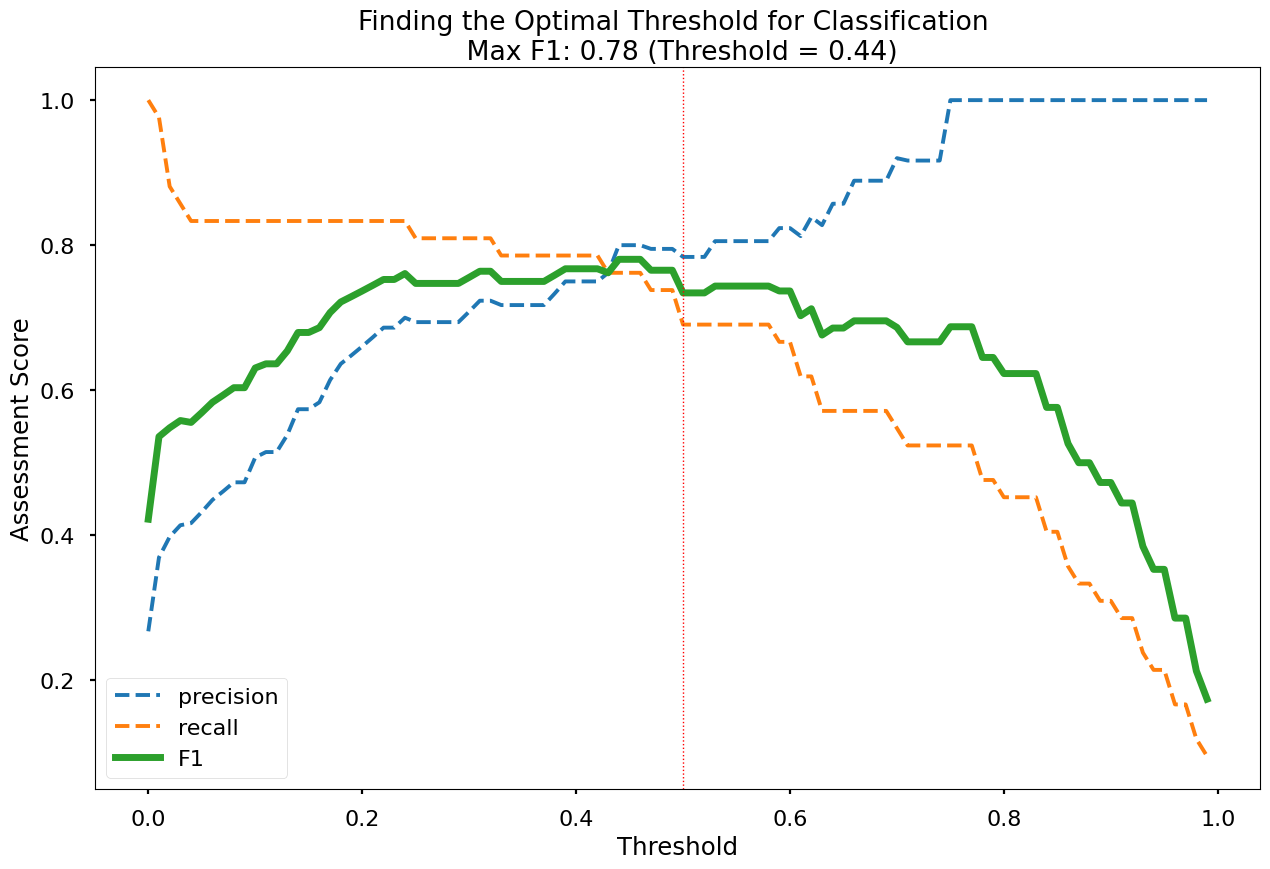

In [162]:
plt.style.use('seaborn-v0_8-poster')

plt.plot(thresholds, precision_scores, label='precision', linestyle = '--')
plt.plot(thresholds, recall_scores, label='recall', linestyle = '--')
plt.plot(thresholds, f1_scores, label='F1', linewidth = 5)
plt.axvline(0.5, color = 'red', linestyle = ':', linewidth = 1)

plt.title(f'Finding the Optimal Threshold for Classification \n Max F1: {round(max_f1,2)} (Threshold = {round(thresholds[max_f1_idx],2)})')
plt.xlabel('Threshold')
plt.ylabel('Assessment Score')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

In [160]:
# Get the predictions for the optimal threshold of prediction of the logistic model
optimal_threshold = 0.44
y_pred_class_opt_thresh = (y_pred_prob >= optimal_threshold) * 1

In [161]:
pd.DataFrame(y_pred_class_opt_thresh)

,0
0,0
1,0
2,1
3,0
4,0
...,...
152,0
153,0
154,0
155,1
